# MoodMirror: Speech Emotion Recognition

In [36]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount = True)

In [37]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install pyaudio
!pip install json-tricks

In [38]:
%%capture
import os
from json_tricks import load

import numpy as np

import librosa
from pydub import AudioSegment, effects
import noisereduce as nr

import tensorflow as tf
import keras
from keras.models import model_from_json
from keras.models import load_model

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# **LOAD MODEL**
Loading the speech emotion recognition LSTM model and weights.

In [39]:
saved_model_path = r'./model8723.json'
saved_weights_path = r'./model8723_weights.h5'

#Reading the model from JSON file
with open(saved_model_path, 'r') as json_file:
    json_savedModel = json_file.read()
    
# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 448, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
Total params: 54024 (211.03 KB)
Trainable params: 54024 (211.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


# DATA PREPROCESSING

An audio input .wav file is processed similarly to the model's preprocess in the following order:


*   Sample rate: number of audio samples per second is extracted by `librosa`.
*   'AudioSegment' instance: The audio is loaded to an object by the `AudioSegment` module of `pydub`.
*   Normalization: The 'AudioSegment' object is normalized to + 5.0 dBFS, by `effects` module of `pydub`. 
*   Transforming the object to an array of samples by `numpy` & `AudioSegment`.
*   Noise reduction is being performed by `noisereduce`.

Speech features are extracted as well:
1.   Energy - Root Mean Square (RMS)
2.   Zero Crossed Rate (ZCR)
3.   Mel-Frequency Cepstral Coefficients (MFCCs) 

With `frame_length = 2048`, `hop_lentgh = 512`, assuring equally sequential length. 

The features are concatenated to an '`X`' variable, adjusted to fit the expected shape of the model: (batch, timesteps, feature). The function returns '`X_3D`' variable.

In [44]:
def preprocess(file_path, frame_length = 2048, hop_length = 512):
    total_length = 204288 
    _, sr = librosa.load(path = file_path, sr = None)
    rawsound = AudioSegment.from_file(file_path) 
    normalizedsound = effects.normalize(rawsound, headroom = 5.0) 
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32') 
    final_x = nr.reduce_noise(normal_x, sr=sr) 
    # Features extraction 
    f1 = librosa.feature.rms(y = final_x, frame_length=frame_length, hop_length=hop_length,center=True,pad_mode='reflect').T
    f2 = librosa.feature.zero_crossing_rate(final_x , frame_length=frame_length, hop_length=hop_length, center=True).T      
    f3 = librosa.feature.mfcc(y = final_x, sr=sr, n_mfcc=13, hop_length = hop_length).T
    X = np.concatenate((f1, f2, f3), axis = 1)
    padding_rows = 448-len(X)
    X = np.vstack(( X, np.zeros((padding_rows, 15))))
    X_3D = np.expand_dims(X, axis=0)
    
    return X_3D

# **ADDITIONAL SETUP**
- An **emotion list** is defined to translate the model prediction output to a readable form.

- `is_silent` function is executed as a boolean state if silence of sequential audio was found. `is_silent` returns `True` when the maximum signal within the sequence is less than the threshold value defined.

In [45]:
# Emotions list is created for a readable form of the model prediction.

emotions = {
    0 : 'neutral',
    1 : 'calm',
    2 : 'happy',
    3 : 'sad',
    4 : 'angry',
    5 : 'fearful',
    6 : 'disgust',
    7 : 'suprised'   
}
emo_list = list(emotions.values())

def is_silent(data):
    # Returns 'True' if below the 'silent' threshold
    return max(data) < 100


# REAL-TIME IMPLEMENTATION

This implementation of an LSTM Speech Emotion Recognition model carries out a real-time emotion prediction of an audio input, recorded from the soundcard of the platform.
The process includes the following:


1.   Session start, opening a connection with the input channel by `pyaudio`.
2.   If **not silent**, the input signals will be recorded to a .wav file, by `pyaudio` and `wave`.

    2.1  After 7.1 seconds, the recording will stumble in order to send the last .wav file to the rest of the process before start recording a new one.

    2.2  The .wav file is preprocessed, in `preprocess` function.

    2.3  `model.predict` is executed, an array of 8 emotion probabilities is returned. E.g. `predictions = [array([p_neutral, p_calm, p_happy, p_sad, p_angry, p_feaful, p_disgust, p_suprised], dtype=float32)]`

    2.4   `predictions` are transformed to a compact representation (without 'array' and 'dtype' statements) and saved in a list.

    2.5 A visualization of `predictions` is shown by `matplotlib`.

3.   Else, if silence is identified within the last 2 seconds of a .wav file:

    3.1  Break; end of the session; close connections.

    3.2 Visualize a summary of the session: Mean value of the predictions.

    3.3 State the overall session time.


## VARIABLES EXPLAINED
RATE = Sample rate = 24414 which is the sample rate of most of the model's train data.

CHUNK = A batch of sequential samples to process at once. Similar to 'hop_length' by `librosa`, defined 512.

FORMAT = Sampling size and format, 32bit as in the model.

CHANNELS = 1 for mono, a standard of audio recording in PC / cellphones.

** session started
* recording...
* done recording
x shape: (1, 448, 15)
1/1 [==============================] - 0s 66ms/step


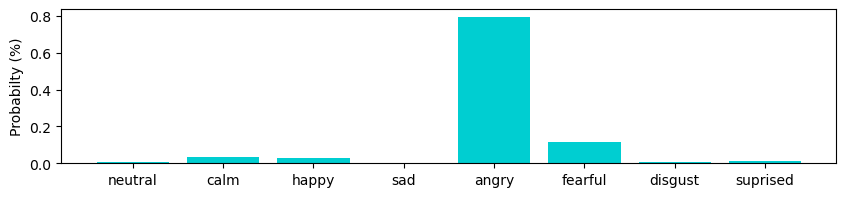

max emotion: angry
----------------------------------------------------------------------------------------------------
* recording...
* done recording
x shape: (1, 448, 15)
1/1 [==============================] - 0s 64ms/step


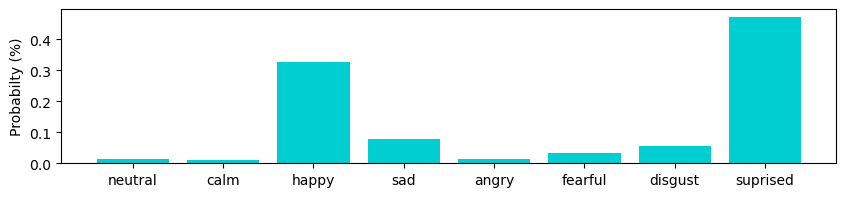

max emotion: suprised
----------------------------------------------------------------------------------------------------
* recording...
* done recording
x shape: (1, 448, 15)
1/1 [==============================] - 0s 57ms/step


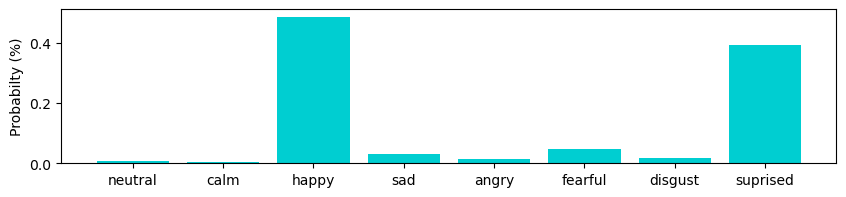

max emotion: happy
----------------------------------------------------------------------------------------------------
* recording...
* done recording
x shape: (1, 448, 15)
1/1 [==============================] - 0s 52ms/step


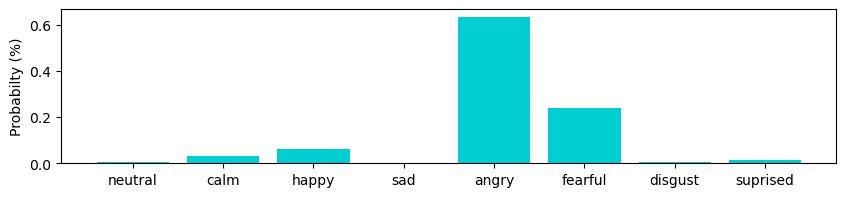

max emotion: angry
----------------------------------------------------------------------------------------------------
* recording...
* done recording
x shape: (1, 448, 15)
1/1 [==============================] - 0s 51ms/step


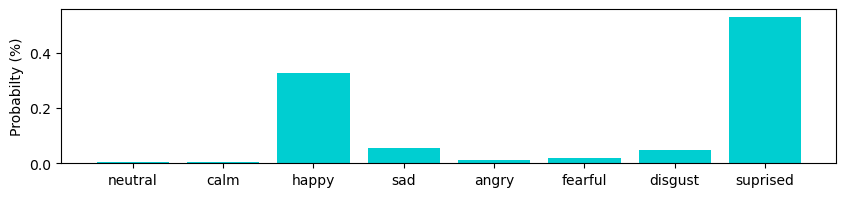

max emotion: suprised
----------------------------------------------------------------------------------------------------
* recording...
* done recording
x shape: (1, 448, 15)
1/1 [==============================] - 0s 51ms/step


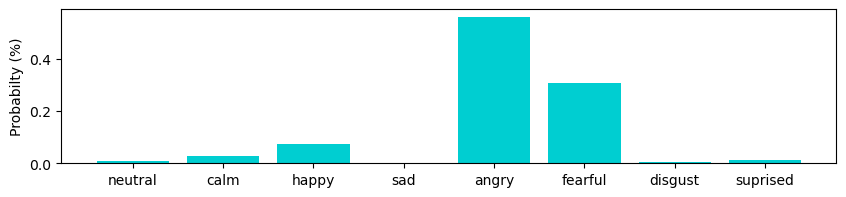

max emotion: angry
----------------------------------------------------------------------------------------------------
* recording...
* done recording
x shape: (1, 448, 15)
1/1 [==============================] - 0s 49ms/step


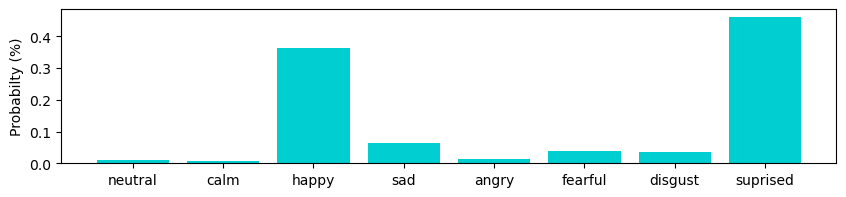

max emotion: suprised
----------------------------------------------------------------------------------------------------
* recording...
* done recording
x shape: (1, 448, 15)
1/1 [==============================] - 0s 58ms/step


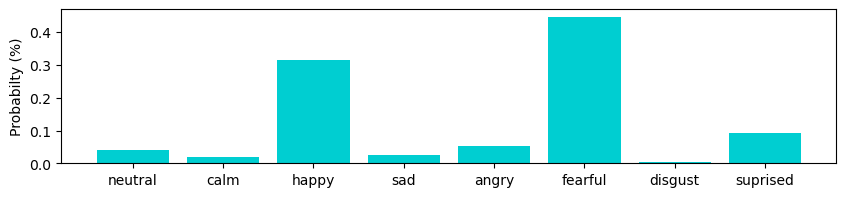

max emotion: fearful
----------------------------------------------------------------------------------------------------
* recording...
* done recording
x shape: (1, 448, 15)
1/1 [==============================] - 0s 56ms/step


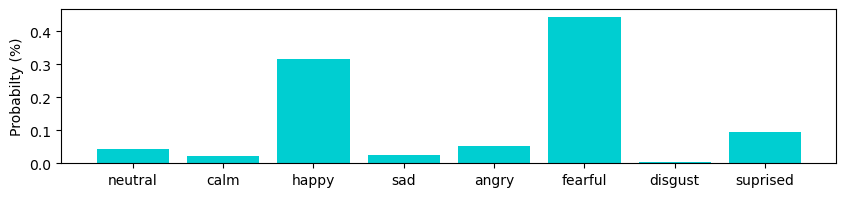

max emotion: fearful
----------------------------------------------------------------------------------------------------
* recording...
* done recording
x shape: (1, 448, 15)
1/1 [==============================] - 0s 61ms/step


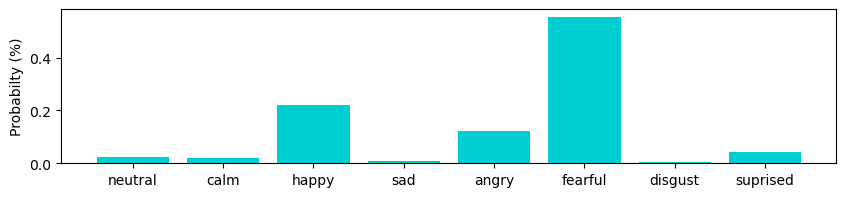

max emotion: fearful
----------------------------------------------------------------------------------------------------
* recording...
* done recording
x shape: (1, 448, 15)
1/1 [==============================] - 0s 56ms/step


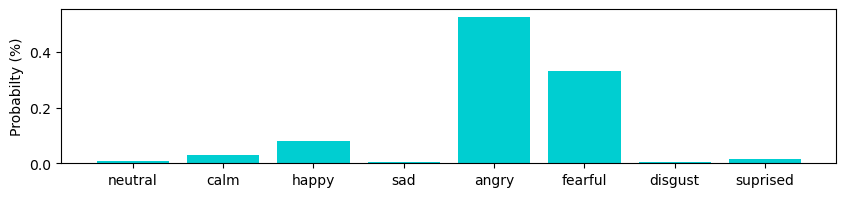

max emotion: angry
----------------------------------------------------------------------------------------------------
* recording...
* done recording
x shape: (1, 448, 15)
1/1 [==============================] - 0s 58ms/step


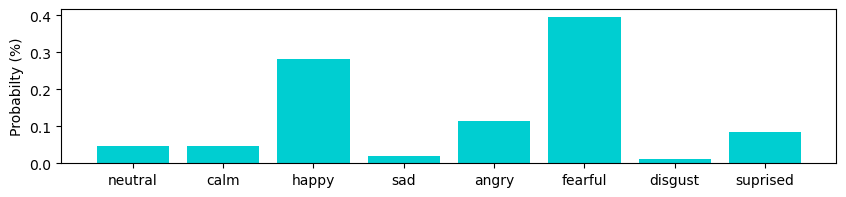

max emotion: fearful
----------------------------------------------------------------------------------------------------
* recording...
* done recording
x shape: (1, 448, 15)
1/1 [==============================] - 0s 66ms/step


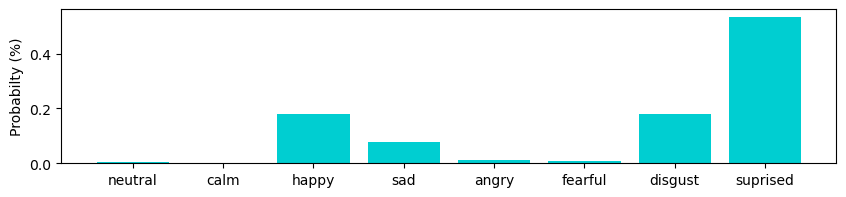

max emotion: suprised
----------------------------------------------------------------------------------------------------
* recording...
* done recording
x shape: (1, 448, 15)
1/1 [==============================] - 0s 65ms/step


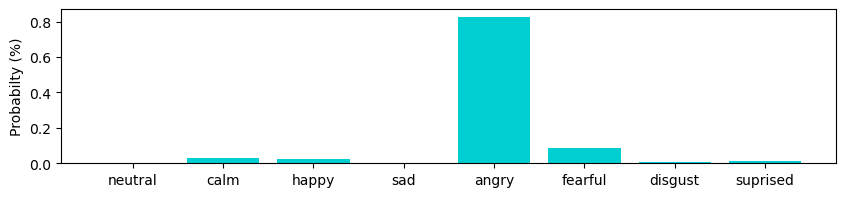

max emotion: angry
----------------------------------------------------------------------------------------------------
** session ended


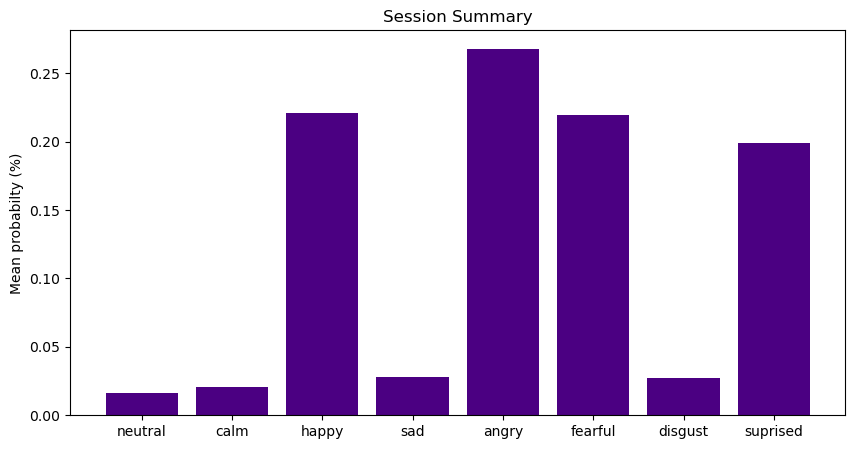

Emotions analyzed for: 102.7456 seconds


In [46]:
import pyaudio
import wave
from array import array
import struct
import time

# Initialize variables
RATE = 24414
CHUNK = 512
RECORD_SECONDS = 7.1


FORMAT = pyaudio.paInt32
CHANNELS = 1
WAVE_OUTPUT_FILE = "./output.wav"

# Open an input channel
p = pyaudio.PyAudio()
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)


# Initialize a non-silent signals array to state "True" in the first 'while' iteration.
data = array('h', np.random.randint(size = 512, low = 0, high = 500))

# SESSION START
print("** session started")
total_predictions = [] # A list for all predictions in the session.
tic = time.perf_counter()

while is_silent(data) == False:
    print("* recording...")
    frames = [] 
    data = np.nan # Reset 'data' variable.

    timesteps = int(RATE / CHUNK * RECORD_SECONDS) # => 339

    # Insert frames to 'output.wav'.
    for i in range(0, timesteps):
        data = array('l', stream.read(CHUNK)) 
        frames.append(data)

        wf = wave.open(WAVE_OUTPUT_FILE, 'wb')
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(p.get_sample_size(FORMAT))
        wf.setframerate(RATE)
        wf.writeframes(b''.join(frames))

    print("* done recording")

    x = preprocess(WAVE_OUTPUT_FILE) # 'output.wav' file preprocessing.
    print('x shape:', x.shape)
    # Model's prediction => an 8 emotion probabilities array.
    predictions = model.predict(x, use_multiprocessing=True)
    pred_list = list(predictions)
    pred_np = np.squeeze(np.array(pred_list).tolist(), axis=0) # Get rid of 'array' & 'dtype' statments.
    total_predictions.append(pred_np)
    
    # Present emotion distribution for a sequence (7.1 secs).
    fig = plt.figure(figsize = (10, 2))
    plt.bar(emo_list, pred_np, color = 'darkturquoise')
    plt.ylabel("Probabilty (%)")
    plt.show()
    
    max_emo = np.argmax(predictions)
    print('max emotion:', emotions.get(max_emo,-1))
    
    print(100*'-')
    
    # Define the last 2 seconds sequence.
    last_frames = np.array(struct.unpack(str(96 * CHUNK) + 'B' , np.stack(( frames[-1], frames[-2], frames[-3], frames[-4],
                                                                            frames[-5], frames[-6], frames[-7], frames[-8],
                                                                            frames[-9], frames[-10], frames[-11], frames[-12],
                                                                            frames[-13], frames[-14], frames[-15], frames[-16],
                                                                            frames[-17], frames[-18], frames[-19], frames[-20],
                                                                            frames[-21], frames[-22], frames[-23], frames[-24]),
                                                                            axis =0)) , dtype = 'b')
    if is_silent(last_frames): # If the last 2 seconds are silent, end the session.
        break

# SESSION END        
toc = time.perf_counter()
stream.stop_stream()
stream.close()
p.terminate()
wf.close()
print('** session ended')

# Present emotion distribution for the whole session.
total_predictions_np =  np.mean(np.array(total_predictions).tolist(), axis=0)
fig = plt.figure(figsize = (10, 5))
plt.bar(emo_list, total_predictions_np, color = 'indigo')
plt.ylabel("Mean probabilty (%)")
plt.title("Session Summary")
plt.show()

print(f"Emotions analyzed for: {(toc - tic):0.4f} seconds")